# **Biquadratic Presence Filter**
Alken Rrokaj

Implement the design procedure for notch and resonance filters found in the paper, and validate your implementation by filtering several (one or more) well-chosen input signals and visualizing the output. Make sure that you choose realistic input signals (ex., signals that you can encounter in real-life), and explain why the results show the correct operation of your notch and resonance filter implementation. \
\
There are some known issues when designing a resonance filter with $\frac{G_c}{G_0}<2$. You can dismiss this case in your implementation.
$$ H(z)=K \frac{1-2 r_z \cos \omega_c z^{-1}+r_z^2 z^{-2}}{1-2 r_p \cos \omega_c z^{-1}+r_p^2 z^{-2}} $$

### **Output:**
- A single code file containing the implementation for the design procedure consisting of a single function named designBiquadFilter with the following fixed input parameters: gain at DC (G0), gain at resonance (Gc), bandwidth in radians (B), center frequency in radians (wc). This function has to return the numerator and denominator coefficients for the designed biquadratic filter.
- A single code file validating your implementation by filtering with well-chosen input signals and visualizing the output.
- Any test signals saved as separate files that you used in your evaluation.

In [15]:
%matplotlib inline 
import math 
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

In [16]:
# Definition of the designBiquadFilter function

# w_c: center frequency in radians
# G_0: gain at DC
# G_c: gain at resonance
# B: bandwidth in radians
 
def designBiquadFilter(w_c, G_0, G_c, B):
    r_z, r_p = 0, 0
    
    if G_0>G_c:
        # notch
        if G_c/G_0 <= 1/2:
            r_z = 1 - (B/2)*math.sqrt(1-2*(G_c/G_0)**2)
            r_p = 1 - (B/2)*math.sqrt((G_0/G_c)**2-2)
        else:
            r_z = 1 - (B/2)*math.sqrt(G_c/G_0)
            r_p = 1 - (B/2)*math.sqrt(G_0/G_c)
        K = G_0
    
    else:
        # resonance
        if G_c/G_0 >= 2:
            r_p = 1 - B/2
            gamma = (B/2) * (G_c/G_0) * (math.sin(w_c) / (1-math.cos(w_c)))
            r_z = (1 - gamma)/(1 - gamma + B/2*(G_c/G_0))
        else:
            r_p = 1 - B/(2*math.sqrt((G_c/G_0)-1))
            gamma = ( B/(2*math.sqrt((G_c/G_0)-1))) * G_c/G_0 * math.sin(w_c)/(1-math.cos(w_c))
            r_z = (1 - gamma)/(1 - gamma + (B/(2*math.sqrt((G_c/G_0)-1))) *(G_c/G_0))

        K = G_0 * (1-2*r_p*math.cos(w_c)+r_p**2) / (1-2*r_z*math.cos(w_c)+r_z**2)
    
    # filter
    num = np.array([ 1, (-2)*r_z*math.cos(w_c), r_z**2])
    num = np.multiply(num,K)
    den = np.array([ 1, -2*r_p*math.cos(w_c), r_p**2])

    return (num,den)

## **Testing with the Paper's Design Examples**

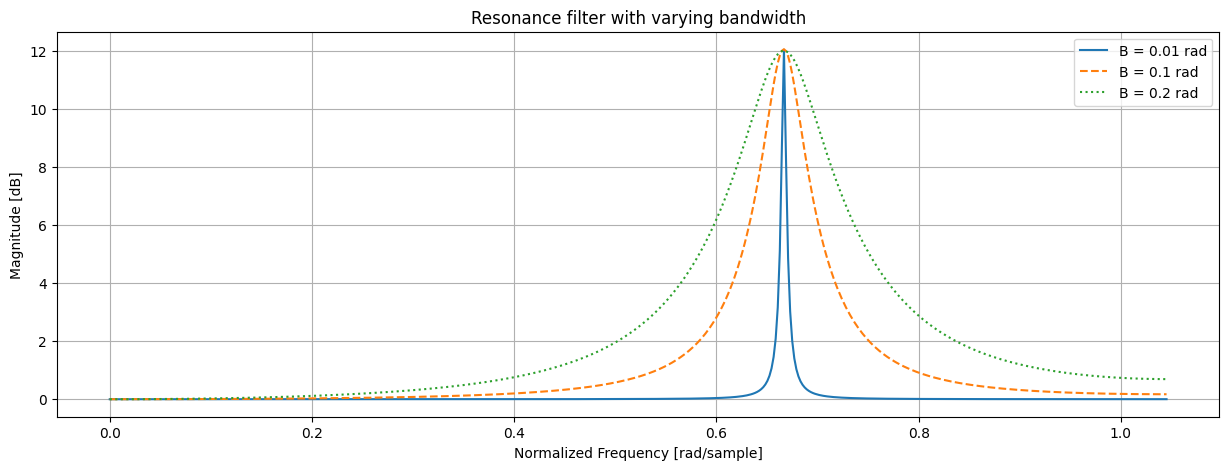

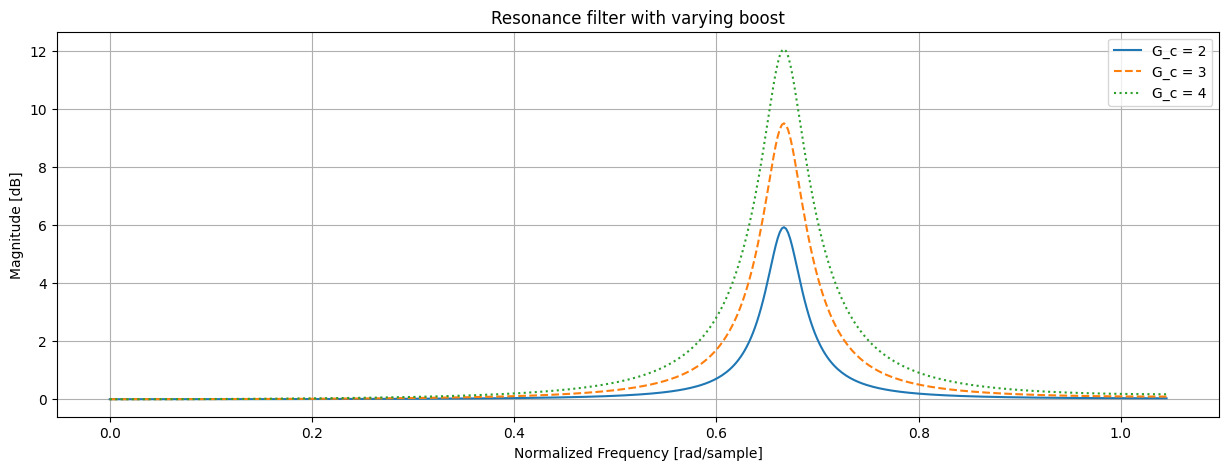

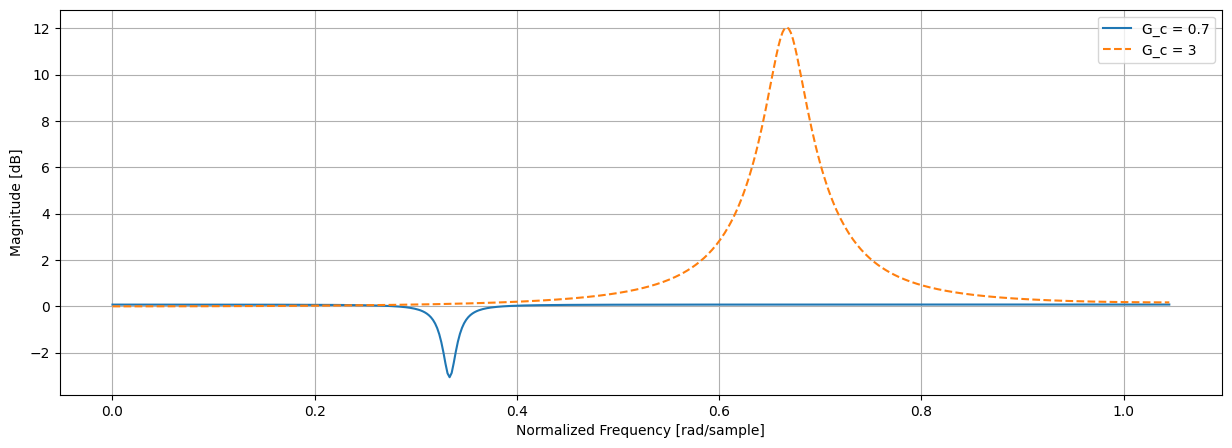

In [17]:
# Resonance
w_c = 2  # rad (0.64pi rad)
G_0 = 1  # 0 db
G_c = 4  # 12 db

plt.figure(figsize=(15, 5))
num, den = designBiquadFilter(w_c, G_0, G_c, 0.01)
w, H = signal.freqz(num,den)
plt.plot(w/3, 20*np.log10(H),label = 'B = 0.01 rad')

num, den = designBiquadFilter(w_c, G_0, G_c, 0.1)
w, H = signal.freqz(num,den)
plt.plot(w/3, 20*np.log10(H),ls="--",label = 'B = 0.1 rad')

num, den= designBiquadFilter(w_c, G_0, G_c, 0.2)
w, H = signal.freqz(num,den)
plt.plot(w/3, 20*np.log10(H), ls=":", label = 'B = 0.2 rad')
plt.xlabel('Normalized Frequency [rad/sample]')
plt.ylabel('Magnitude [dB]')
plt.legend(loc="best")
plt.title('Resonance filter with varying bandwidth')
plt.grid()
plt.show()


B = 0.1 # rad (0.032 pi rad)
plt.figure(figsize=(15, 5))
num, den= designBiquadFilter(w_c, G_0, 2, B)
w, H = signal.freqz(num,den)
plt.plot(w/3, 20*np.log10(H),label = 'G_c = 2')

num, den = designBiquadFilter(w_c, G_0, 3, B)
w, H = signal.freqz(num,den)
plt.plot(w/3, 20*np.log10(H),ls="--",label = 'G_c = 3')

num, den = designBiquadFilter(w_c, G_0, 4, B)
w, H = signal.freqz(num,den)
plt.plot(w/3, 20*np.log10(H), ls=":", label = 'G_c = 4')
plt.xlabel('Normalized Frequency [rad/sample]')
plt.ylabel('Magnitude [dB]')
plt.legend(loc="best")
plt.title('Resonance filter with varying boost')
plt.grid()
plt.show()


# Resonance
plt.figure(figsize=(15, 5))
num, den = designBiquadFilter(1, 1, 0.7, 0.05)
w, H = signal.freqz(num,den)
plt.plot(w/3, 20*np.log10(H),label = 'G_c = 0.7')

num, den = designBiquadFilter(2, 1, 4, 0.1)
w, H = signal.freqz(num,den)
plt.plot(w/3, 20*np.log10(H),ls="--",label = 'G_c = 3')

plt.xlabel('Normalized Frequency [rad/sample]')
plt.ylabel('Magnitude [dB]')
plt.legend(loc="best")
plt.grid()
plt.show()

## **Application in a Real Life Signal** 

### **1. Notch Filter**
The signal used is an audio signal made of three components/instruments. Each of those components lies on a different part of the frequency spectrum. \
\
![logic](./data/Logic.png) 

The goal of this application is to filter out one of the components without affecting the other two.

In [18]:
import librosa
import librosa.display
import IPython.display as ipd
from scipy.io.wavfile import write 

In [19]:
original,sr = librosa.load('./data/original.wav')
ipd.Audio(original, rate=sr)

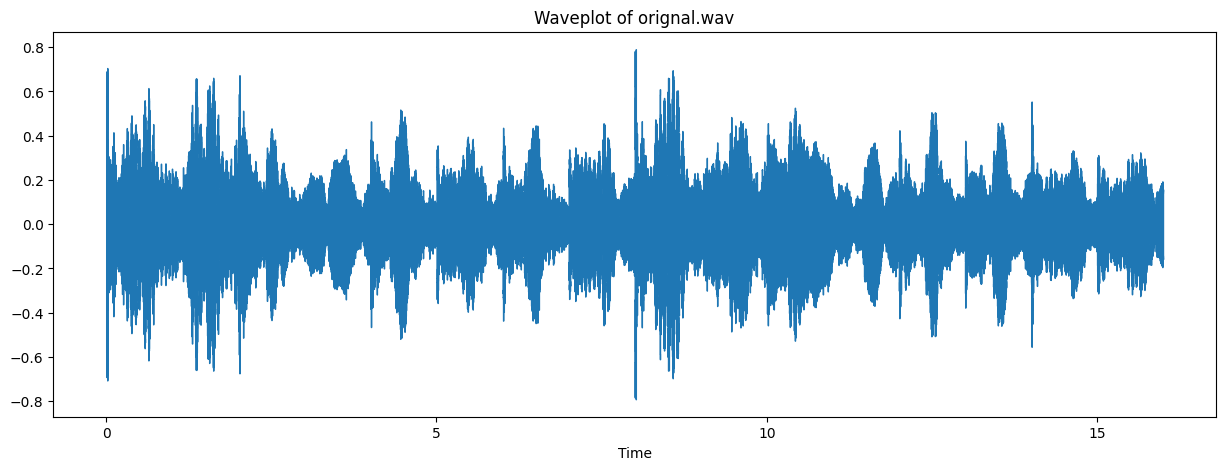

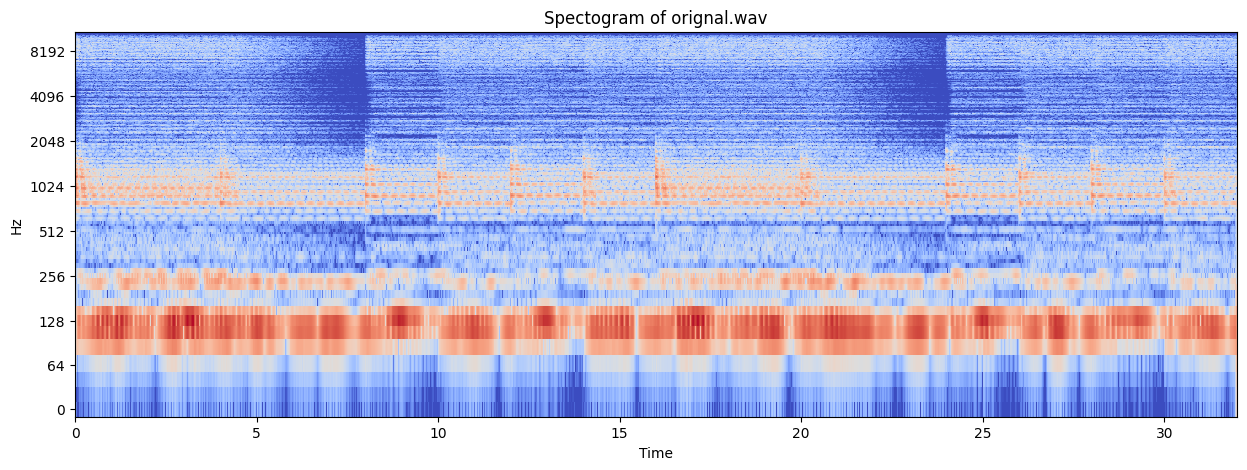

In [20]:
# Waveplot
plt.figure(figsize=(15, 5))
plt.title('Waveplot of orignal.wav')
librosa.display.waveshow(original, sr=sr)

# Spectogram
original_stft = librosa.stft(original,n_fft=1024)
original_stft_db = librosa.amplitude_to_db(original_stft)
plt.figure(figsize=(15, 5))
plt.title('Spectogram of orignal.wav')
librosa.display.specshow(original_stft_db, sr=sr, x_axis='time', y_axis='log')


From the above spectogram we can see three distinct instruments playing at the C3, C4 and C6 octaves, around 128, 256, 1024 Hz.

Now onto filtering the signal.

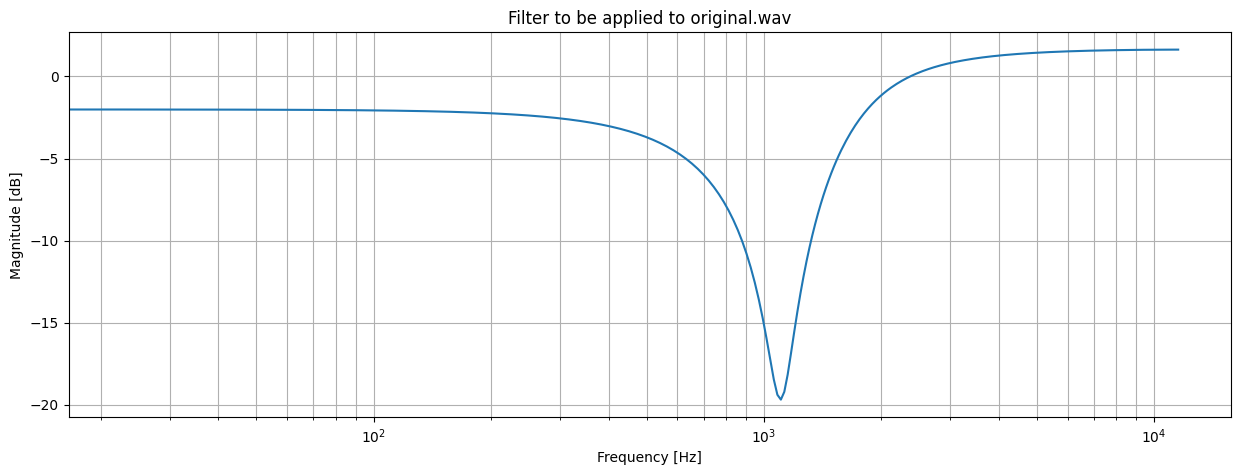

In [21]:
num, den = designBiquadFilter( 0.3, 1, 0.10, 0.04)
w, H = signal.freqz(num,den)

plt.figure(figsize=(15, 5))
plt.title('Filter to be applied to original.wav')
plt.plot(w/3*sr/2, 20*np.log10(H))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.xscale('log')
plt.grid(True, which="both", ls="-")
plt.show()

In [22]:
filtered = signal.lfilter(num,den,original)
ipd.Audio(filtered, rate=sr)

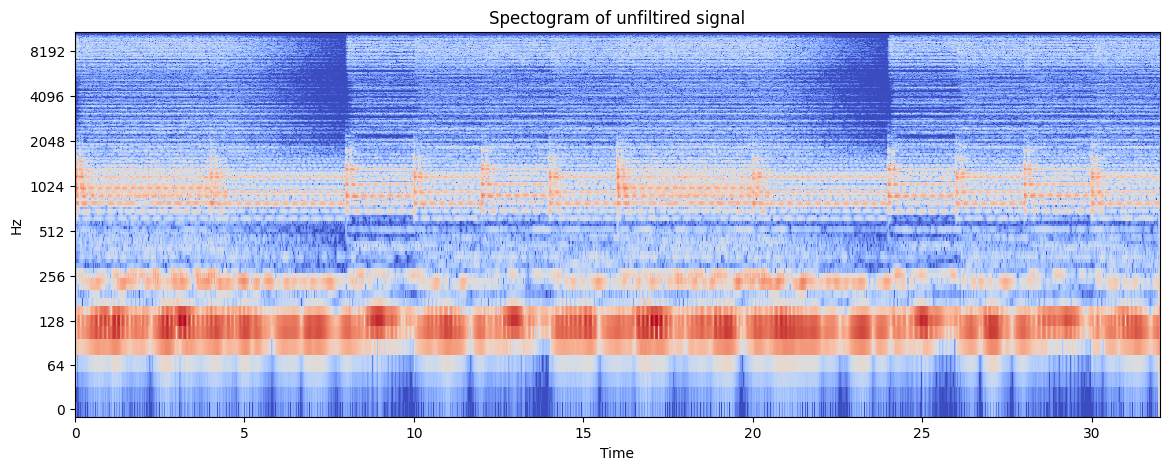

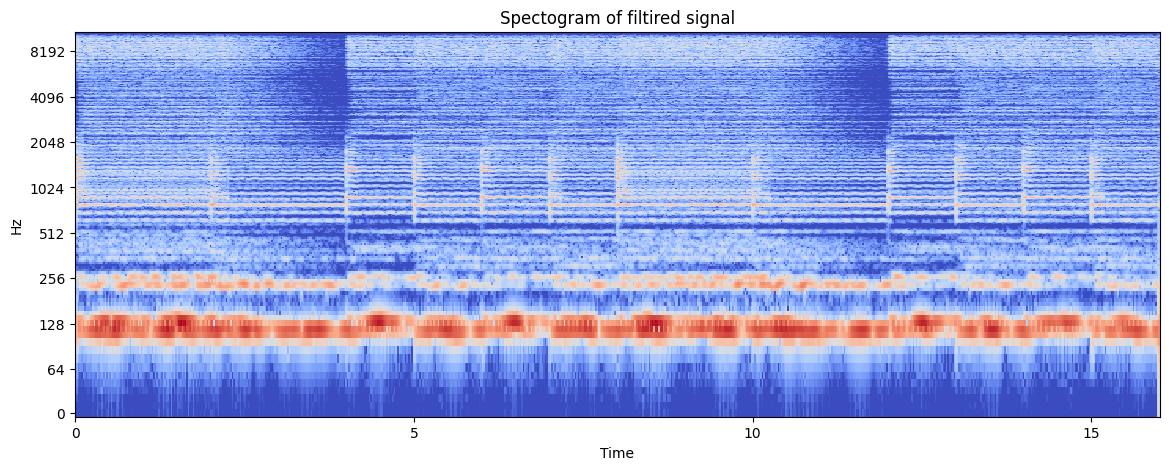

In [23]:
# Spectogram
filtered_stft = librosa.stft(filtered)
filtered_stft_db = librosa.amplitude_to_db(abs(filtered_stft))

plt.figure(figsize=(14, 5))
plt.title("Spectogram of unfiltired signal")
librosa.display.specshow(original_stft_db, sr=sr, x_axis='time', y_axis='log')

plt.figure(figsize=(14, 5))
plt.title("Spectogram of filtired signal")
librosa.display.specshow(filtered_stft_db, sr=sr, x_axis='time', y_axis='log')

We have effectivly attenuated the signal at C6 / 1024 Hz, without majorly affecting the other two signals. 

Save it to the audio folder.

In [24]:
write("./data/filtered.wav", sr, filtered) 

### **2. Resonance Filter + Negative DC Gain**
The following signal is composed of drums, piano and a high pitch wind instrument *(I think)*.

In [25]:
song_before,sr = librosa.load('./data/song_before.wav')
ipd.Audio(song_before, rate=sr)

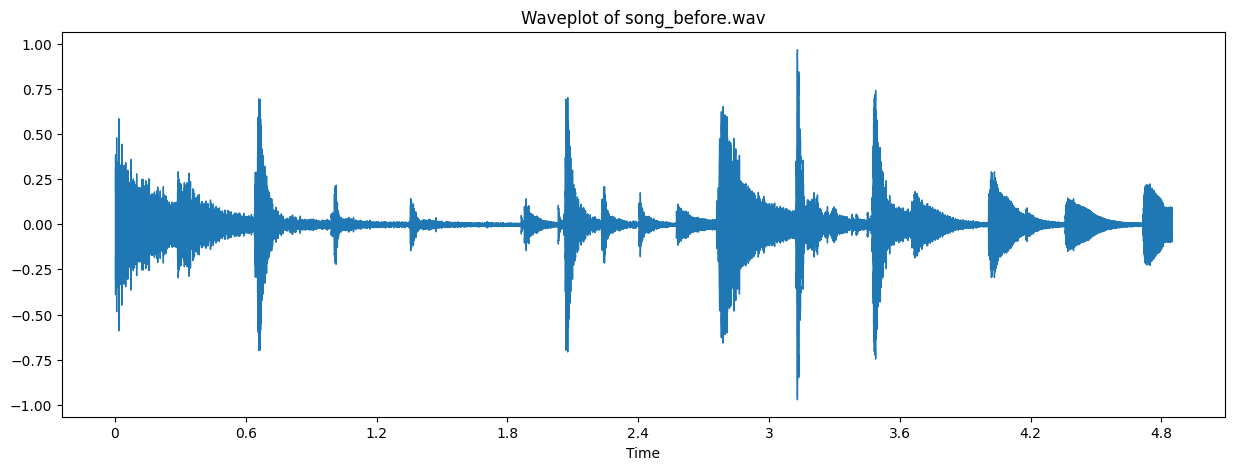

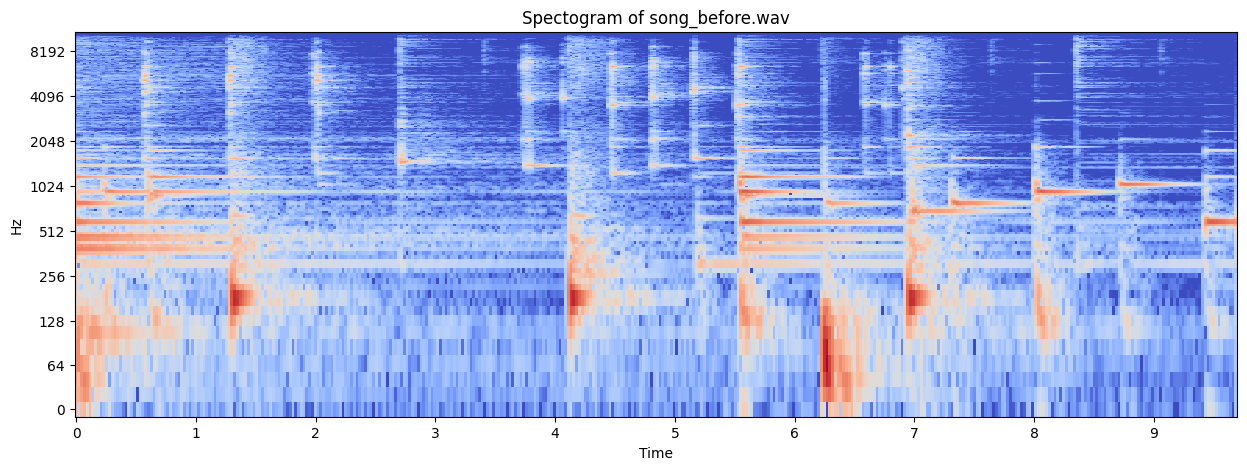

In [26]:
# Waveplot
plt.figure(figsize=(15, 5))
plt.title('Waveplot of song_before.wav')
librosa.display.waveshow(song_before, sr=sr)

# Spectogram
song_before_stft = librosa.stft(song_before,n_fft=1024)
song_before_stft_db = librosa.amplitude_to_db(song_before_stft)
plt.figure(figsize=(15, 5))
plt.title('Spectogram of song_before.wav')
librosa.display.specshow(song_before_stft_db, sr=sr, x_axis='time', y_axis='log')


From the above spectogram we can see that the sound is spread out more than the previous signal. 

We are now going to filter the signal to retain only the high-pitch wind instrument.

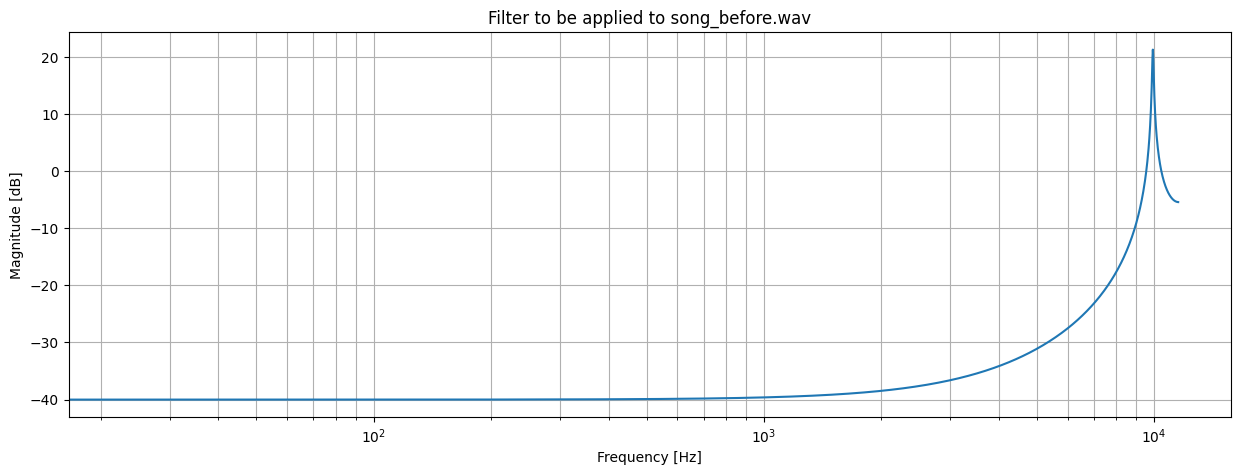

In [27]:
num, den = designBiquadFilter( 2.7, 0.01, 100, 0.02)
w, H = signal.freqz(num,den)

plt.figure(figsize=(15, 5))
plt.title('Filter to be applied to song_before.wav')
plt.plot(w/3*sr/2, 20*np.log10(H))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.xscale('log')
plt.grid(True, which="both", ls="-")
plt.show()

In [28]:
song_after = signal.lfilter(num,den,song_before)
ipd.Audio(song_after, rate=sr)

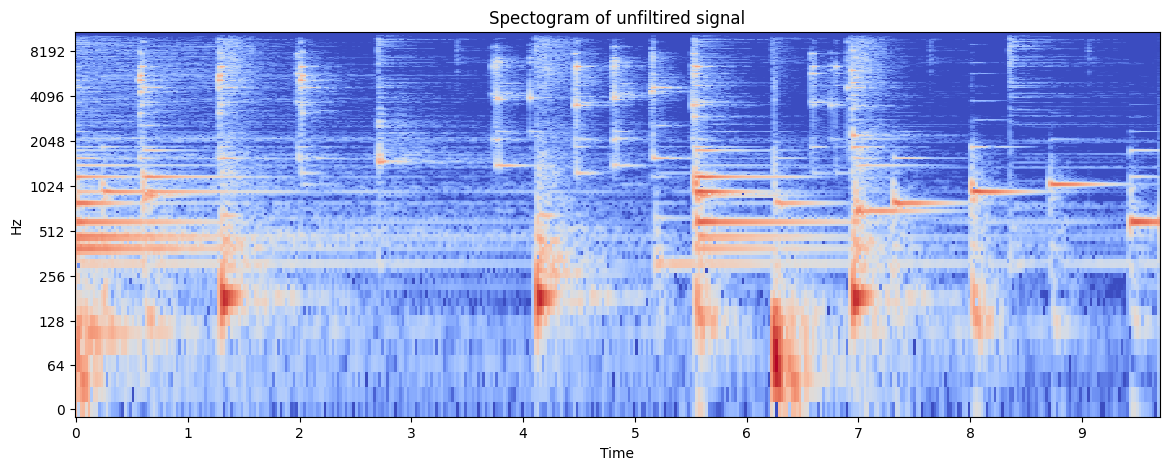

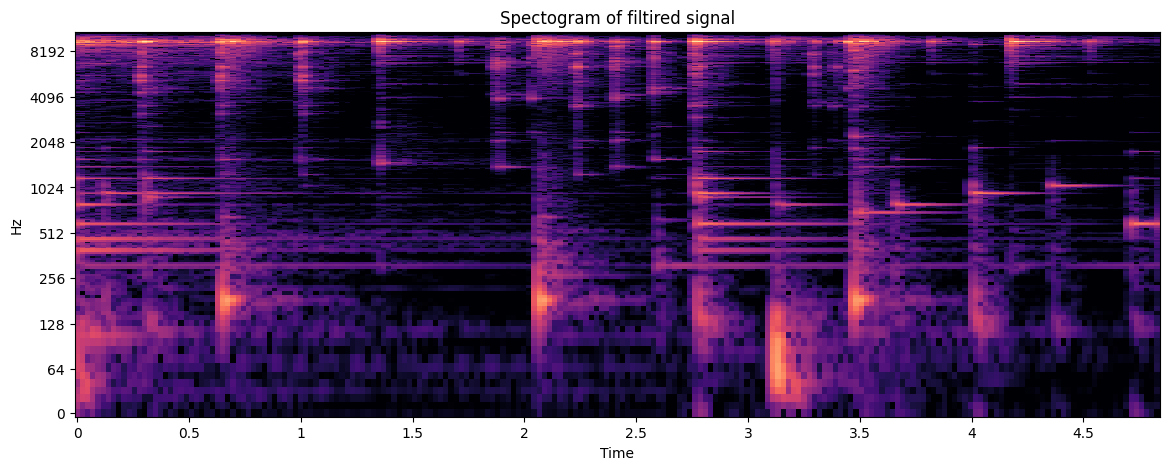

In [29]:
# Spectogram
song_after_stft = librosa.stft(song_after)
song_after_stft_db = librosa.amplitude_to_db(abs(song_after_stft))

plt.figure(figsize=(14, 5))
plt.title("Spectogram of unfiltired signal")
librosa.display.specshow(song_before_stft_db, sr=sr, x_axis='time', y_axis='log')

plt.figure(figsize=(14, 5))
plt.title("Spectogram of filtired signal")
librosa.display.specshow(song_after_stft_db, sr=sr, x_axis='time', y_axis='log')

The wind instrument is clearly present in the song_after file, however some of the piano notes in the higher frequencies can still be heard. 

In [ ]:
write("./data/song_after.wav", sr, song_after) 